In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import copy

In [2]:
class action_embedder(nn.Module):
    def __init__(self, n_actions, embedding_size):
        super(action_embedder,self).__init__()
        self.embedding_layer = nn.Linear(n_actions,embedding_size)
    
    def forward(self, x):
        return self.embedding_layer(x)


class obs_convolver(nn.Module):
    def __init__(self):
        super(obs_convolver, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 8, stride = 4)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 2, stride = 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return F.relu(self.conv3(x)).flatten()

class ADRQN(nn.Module):
    def __init__(self, n_actions, embedding_size):
        super(ADRQN, self).__init__()
        self.embedder = action_embedder(n_actions, embedding_size)
        self.convolver = obs_convolver()
        self.lstm = nn.LSTM(input_size = 4096+embedding_size, hidden_size = embedding_size)
        self.out_layer = nn.Linear(embedding_size, n_actions)
        
    def forward(self, observation, action, hidden_state = None, cell_state = None):
        action_embedded = self.embedder(action)
        observation_conved = self.convolver(observation.unsqueeze(0))
        lstm_input = torch.cat([observation_conved, action_embedded]).view(1,1,-1)
        if hidden_state is not None:
            lstm_out, (hn, cn) = self.lstm(lstm_input, (hidden_state, cell_state))
        else:
            lstm_out, (hn, cn) = self.lstm(lstm_input)
        
        q_values = self.out_layer(lstm_out)
        return q_values, (hn, cn)    

def onehot_action(n_actions, action_idx):
    return torch.tensor([int(i == action_idx) for i in range(n_actions)], dtype = torch.float32)

def preprocess_obs(obs):
    obs = torch.tensor(obs, dtype = torch.float32).permute(2,0,1)
    obs = F.interpolate(obs.unsqueeze(0), size = (84,84))
    return obs[:,1,:,:]
    

In [3]:
class ExpBuffer():
    def __init__(self, max_episodes):
        self.max_episodes = max_episodes
        self.current_episode = -1
        self.filled_episodes = 0
        self.storage = [[] for i in range(max_episodes)]
    
    def init_episode(self):
        self.current_episode += 1
        if self.filled_episodes < self.max_episodes:
            self.filled_episodes += 1
        if self.current_episode == self.max_episodes:
            self.current_episode = 0
            self.storage[self.current_episode] = []
        else:
            self.storage[self.current_episode] = []

    
    def write_tuple(self, aoaro):
        self.storage[self.current_episode].append(aoaro)
    
    def sample(self, n_tuples, max_tries = 1000):
        for i in range(max_tries):
            episode_idx = np.random.randint(self.filled_episodes)
            if len(self.storage[episode_idx]) >= n_tuples:
                break
            if i == max_tries-1:
                raise Exception('Could not find long enough episode. Try reducing n_tuples.')
        start_idx = np.random.randint(len(self.storage[episode_idx]) - n_tuples + 1)
        return self.storage[episode_idx][start_idx:start_idx+n_tuples]

testbuffer = ExpBuffer(5)
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.write_tuple((1,2,3,4,5))
testbuffer.write_tuple((0,2,3,4,5))
testbuffer.write_tuple((1,2,99,23,5))
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.sample(2)
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.write_tuple((1,2,99,23,5))
testbuffer.write_tuple((1,2,99,23,5))
#testbuffer.write_tuple((1,2,99,23,5))
#testbuffer.write_tuple((1,2,99,23,5))
#testbuffer.write_tuple((1,2,99,23,5))
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.write_tuple((1,2,3,4))
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.write_tuple((1,2,3,4))
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.write_tuple((1,2,3,4))
#testbuffer.write_tuple((1,2,3,4))
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.write_tuple((1,2,3,4))
print(testbuffer.storage, testbuffer.current_episode)
testbuffer.init_episode()
print(testbuffer.storage, testbuffer.current_episode)
print(testbuffer.filled_episodes)

[[], [], [], [], []] 0
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [], [], [], []] 0
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [], [], [], []] 1
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [], [], []] 1
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [], [], []] 2
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [(1, 2, 3, 4)], [], []] 3
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [(1, 2, 3, 4)], [(1, 2, 3, 4)], []] 4
[[(1, 2, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 99, 23, 5)], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [(1, 2, 3, 4)], [(1, 2, 3, 4)], [(1, 2, 3, 4)]] 4
[[], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [(1, 2, 3, 4)], [(1, 2, 3, 4)], [(1, 2, 3, 4)]] 0
[[(1, 2, 3, 4)], [(1, 2, 99, 23, 5), (1, 2, 99, 23, 5)], [(1, 2, 3, 4)], [(1, 2, 3, 4)], [(1, 2, 3, 4)]] 0
[[(1,

# Atari Stuff

In [58]:
env = gym.make('Breakout-v0')
observation = preprocess_obs(env.reset())
lastaction = onehot_action(n_actions, 0)
q, hid = adrqn(observation, lastaction)






(tensor([[[-7.4590e-01, -1.0747e-12, -1.1249e-02, -1.8035e-03, -7.5926e-01,
           -3.1341e-02,  1.1327e-08,  7.6093e-01,  2.6288e-06, -2.6812e-06,
           -3.2267e-08,  9.2529e-02, -2.1267e-02,  1.0283e-06, -2.9262e-04,
           -7.5830e-01,  1.7979e-03,  4.5648e-01, -1.8446e-05,  1.2806e-08,
            6.2395e-01,  4.7152e-02,  6.8935e-01,  1.7675e-04, -6.9130e-01,
           -2.4135e-08,  5.9153e-01,  6.5997e-13,  1.9780e-07,  7.6105e-01,
            1.8268e-03,  7.3932e-01, -2.0382e-03,  3.1215e-07, -1.7250e-06,
           -6.2027e-05, -1.4037e-03,  1.1618e-06,  1.6702e-03, -1.2867e-03,
            1.0010e-02, -1.4362e-01,  2.2920e-07, -7.5563e-01,  1.8206e-03,
           -3.7623e-14, -4.8445e-07, -2.3588e-04, -4.4335e-04,  2.6756e-08,
           -1.1718e-16, -5.7801e-12,  3.2895e-14, -1.0415e-01, -1.4819e-08,
           -9.9026e-08, -6.3710e-01,  5.8821e-04,  2.5470e-02,  5.4538e-17,
           -2.8819e-07,  7.2403e-01, -6.2496e-12, -1.5247e-07, -6.3770e-05,
           -

In [4]:
env = gym.make('Breakout-v0')
n_actions = env.action_space.n

adrqn = ADRQN(n_actions, 512)
#observation = torch.tensor(env.reset(), dtype = torch.float32).permute(2,0,1)
#observation = frame_preprocessing(observation)
observation = preprocess_obs(env.reset())

lastaction = onehot_action(n_actions, 0)
q, hid = adrqn(observation, lastaction)
env.render()
action = torch.argmax(q)
observation, reward, done, info = env.step(action)
print(info)

env.close()

{'ale.lives': 5}


In [23]:
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    return tuple(v.data for v in h)

In [62]:
#Yuge Loop
import time

env = gym.make('Pong-v0')
n_actions = env.action_space.n
embedding_size = 512
M_episodes = 750
unroll_length = 10
replay_buffer_size = 10000
replay_buffer = ExpBuffer(replay_buffer_size)
sample_length = 10
batch_size = 10
eps = 0.1
gamma = 0.95


#Init Networks
adrqn = ADRQN(n_actions, 512)
adrqn_target = ADRQN(n_actions, 512)

for param in adrqn_target.parameters():
    param.requires_grad = False

optimizer = torch.optim.SGD(adrqn.parameters(), lr = 0.001)

for i_episode in range(M_episodes):
    now = time.time()
    #print(f'CURRENT EPISODE: {i_episode}')
    done = False
    last_action = 0
    current_return = 0
    last_observation = preprocess_obs(env.reset()) 
    replay_buffer.init_episode()
    while done == False:
        env.render()
        greedy_prob = np.random.uniform()
        if greedy_prob < eps:
            action = np.random.randint(n_actions)
        else:
            qvals, hidden_states = adrqn(last_observation, onehot_action(n_actions,last_action))
            #TODO INCLUDE HIDDEN STATES ABOVE AND INIT THEM SOMEWHERE
            action = int(torch.argmax(qvals))
        
        #print(action)

        observation, reward, done, info = env.step(action)
        current_return += reward
        reward = np.sign(reward)
        observation = preprocess_obs(observation)
        #print(reward)
        replay_buffer.write_tuple((last_action, last_observation, action, reward, observation, done))
        
        last_action = action
        last_observation = observation
    
    
    print(f"Return: {current_return}")
    
    #Updating Networks
    if i_episode > 1:
        #Give the agent some time to explore
        for i_batch in range(batch_size):
            transitions = replay_buffer.sample(sample_length)
            for (j, transition) in enumerate(transitions):
                #...do something
                if  transition[-1] == True:
                    target_value = transition[3]
                elif j == 0:
                    target_inference, target_hidden = adrqn_target(transition[4], onehot_action(n_actions, transition[2]))
                    target_value = transition[3] + gamma*torch.max(target_inference)
                    predicted_value, predicted_hidden = adrqn(transition[1], onehot_action(n_actions, transition[0]))

                else:
                    target_inference, target_hidden = adrqn_target(transition[4], onehot_action(n_actions, transition[2]),
                                                                  target_hidden[0], target_hidden[1])
                    target_value = transition[3] + gamma*torch.max(target_inference)

                optimizer.zero_grad()

                if j == 0:
                    predicted_value, predicted_hidden = adrqn(transition[1], onehot_action(n_actions, transition[0]))
                else:
                    predicted_value, predicted_hidden = adrqn(transition[1], onehot_action(n_actions, transition[0]),
                                                             predicted_hidden[0], predicted_hidden[1])

                loss = (target_value - predicted_value[0,0,transition[2]])**2
                loss.backward()
                optimizer.step()
                predicted_hidden = repackage_hidden(predicted_hidden)


    
    if (i_episode % 2 == 0):
        adrqn_target = copy.deepcopy(adrqn)
        for param in adrqn_target.parameters():
            param.requires_grad = False 
    
    print(f'Finished Episode {i_episode}')
    print(f'Took {time.time()-now}')

env.close()

#TODO: UPDATE TARGET NETWORK OTHERWISE WE DO NOT LEARN ANYTHING

Return: -21.0
Finished Episode 0
Took 13.527665376663208
Return: -20.0
Finished Episode 1
Took 14.385950565338135
Return: -20.0
Finished Episode 2
Took 25.24227476119995
Return: -20.0
Finished Episode 3
Took 24.29126811027527
Return: -21.0
Finished Episode 4
Took 20.80203104019165
Return: -21.0
Finished Episode 5
Took 22.379632711410522
Return: -21.0
Finished Episode 6
Took 22.479005336761475
Return: -21.0
Finished Episode 7
Took 21.610020637512207
Return: -21.0
Finished Episode 8
Took 23.241310119628906
Return: -21.0
Finished Episode 9
Took 22.551593780517578
Return: -21.0
Finished Episode 10
Took 23.28619694709778
Return: -21.0
Finished Episode 11
Took 28.498969554901123
Return: -21.0
Finished Episode 12
Took 22.42091202735901
Return: -21.0
Finished Episode 13
Took 22.428431034088135
Return: -21.0
Finished Episode 14
Took 23.612374544143677
Return: -21.0
Finished Episode 15
Took 22.959685802459717
Return: -21.0
Finished Episode 16
Took 22.61279320716858
Return: -21.0
Finished Episode

KeyboardInterrupt: 

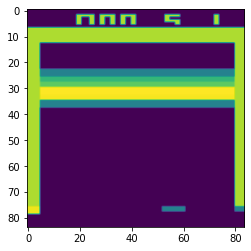

In [48]:
plt.imshow(replay_buffer.sample(50)[20][1][0,:,:])

In [7]:

for i_episode in range(20):
    observation = env.reset()
    for t in range(1000):
        env.render()
        #print(observation)
        action = env.action_space.sample()
        print(action)
        observation, reward, done, info = env.step(action)
        #print(observation.shape)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

2
3
2
1
0
3
2
0
3
1
2
1
3
1
1
3
0
0
3
2
3
1
0
3
3
0
3
2
2
1
1
1
2
1
1
1
1
1
1
1
0
1
1
3
0
0
2
0
0
2
1
2
2
2
3
0
0
0
3
2
2
2
0
2
1
3
0
3
0
0
3
3
1
0
1
2
0
2
2
0
0
3
3
1
2
0
2
1
1
2
3
0
1
0
2
2
3
2
1
0
2
3
3
0
1
2
3
2
2
0
2
1
0
1
3
0
1
0
3
2
0
1
0
0
1
0
2
3
2
1
1
3
3
1
1
2
1
3
0
0
0
3
1
1
3
0
3
3
1
2
0
2
0
0
3
3
1
3
3
1
0
3
0
0
1
1
2
1
0
0
0
2
2
2
1
Episode finished after 175 timesteps
1
2
0
2
1
3
0
3
3
0
1
0
2
3
2
3
0
1
2
2
1
1
1
0
1
2
2
1
0
1
1
2
2
0
3
2
2
1
2
3
1
0
3
1
1
1
3
2
3
0
0
0
2
0
0
0
0
3
0
2
3
2
1
1
3
2
3
3
3
3
2
0
0
3
1
0
1
2
2
0
2
3
2
2
1
1
0
2
0
1
1
2
0
3
2
0
2
0
3
1
2
2
0
2
0
0
1
3
2
2
1
2
1
3
3
0
1
3
1
1
1
0
3
1
3
2
2
0
3
0
0
2
1
2
1
0
2
1
3
0
3
0
0
1
0
2
0
2
1
2
1
0
0
3
1
1
2
0
2
0
3
3
2
1
3
0
2
3
1
2
3
3
1
1
0
3
3
0
2
2
3
2
3
1
0
1
3
1
0
1
2
3
0
2
1
0
1
2
3
0
2
1
0
2
1
0
0
1
1
0
2
0
3
1
1
1
2
3
1
2
3
3
2
3
1
3
0
2
2
3
1
3
3
3
2
1
1
3
2
0
1
1
3
1
0
0
1
1
0
2
3
0
1
0
0
3
0
2
0
1
0
0
1
2
2
3
2
0
2
1
2
3
1
0
0
1
3
1
0
3
0
3
0
3
3
0
3
2
1
2
2
3
2
2
3
3
1
3
3
2
1
2
1
1
0
0
1

0
0
0
0
3
1
0
0
1
0
1
3
0
1
1
3
3
2
2
3
0
3
3
2
1
1
1
3
0
0
2
1
1
0
1
0
3
1
0
3
2
1
3
0
1
0
3
0
2
1
1
3
3
3
1
3
0
2
3
0
1
0
1
0
0
0
3
2
2
0
2
1
3
0
0
3
2
0
1
1
0
2
1
1
3
0
1
2
3
0
2
1
3
1
2
3
1
3
3
0
3
1
3
3
1
1
1
1
2
0
2
Episode finished after 170 timesteps
2
1
3
3
1
3
0
3
0
3
0
2
2
3
1
1
1
2
1
3
3
3
3
1
0
3
0
1
1
2
0
1
1
2
0
3
3
2
1
2
3
1
1
0
3
0
0
3
2
3
1
0
0
1
3
2
2
2
2
2
0
2
3
2
0
3
0
0
2
3
3
2
2
3
2
1
3
1
3
0
1
3
3
2
3
3
2
3
1
1
1
2
3
3
2
1
2
2
0
2
3
3
3
1
0
1
1
3
0
0
3
1
1
2
3
3
3
2
2
2
3
2
1
0
3
2
2
3
1
2
0
3
0
1
0
2
0
0
1
1
3
0
2
3
3
3
1
1
3
0
2
0
0
2
1
0
0
3
1
0
1
3
2
0
3
2
0
1
3
3
3
0
3
1
0
1
1
1
2
0
0
2
0
3
0
1
3
0
1
2
0
1
2
2
2
1
2
0
3
1
3
3
3
2
0
3
0
1
2
2
1
0
2
0
0
1
0
3
1
3
2
2
3
2
2
2
3
1
1
0
0
3
3
2
2
3
3
2
1
0
0
2
2
1
3
0
1
3
2
2
2
0
0
1
0
1
2
0
0
0
2
1
0
3
2
1
2
2
0
3
0
1
3
0
0
3
2
1
1
0
2
1
3
3
3
0
3
2
2
1
0
1
Episode finished after 292 timesteps
2
1
3
1
0
2
2
3
1
2
0
0
2
0
1
0
2
2
1
1
0
0
0
2
1
0
0
2
0
3
0
0
2
2
1
0
3
2
1
3
0
2
2
2
3
0
2
1
3
2
3
3
3
0
2
3
0
0
2
0


In [ ]:
n_actions = 18
embedding_size = 512

x = torch.randn(n_actions)
emb = action_embedder(n_actions, embedding_size)
emb(x)